## Utilities

In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


## Imports

In [2]:
import yaml
import pandas as pd
from tqdm.auto import tqdm
from random import choice
import os
from sklearn.model_selection import train_test_split

In [3]:
from data_preprocessing.text_cleaning import (
    remove_html,
    remove_urls,
    remove_digits,
    remove_punctuation,
    remove_special_characters,
    normalize_whitespace,
    to_lowercase
)
from data_preprocessing.add_domain import add_domain
from data_preprocessing.find_and_remove_duplicates import find_and_remove_dups
from data_preprocessing.balance_data import balance_data, augmentation_threshold

In [4]:
from data_augmentation.paraphrasing import paraphrase
from data_augmentation.style_transfer import transfer_style

In [5]:
from constants import DATASETS

## Load config

In [6]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

## Setup output folder

In [7]:
if not os.path.isdir(config["output"]):
    os.mkdir(config["output"])

## Load Data

In [8]:
data = read_all_datasets()

# -- Orchestration --

## Data Preprocessing

### Find and Remove duplicate Data

In [9]:
datasets = {dataset: read_dataset(dataset) for dataset in DATASETS}
data = find_and_remove_dups(data, datasets)

Total rows                 : 354608
Unique 'text' entries      : 319222
Duplicate 'text' entries   : 35386 (9.98% of total)


==DUPLICATES WITHIN DATASET==
  • Climate-FEVER: 0 duplicates removed, rows 1535→1535 (-0.00%)
  • Fake News Corpus: 7335 duplicates removed, rows 70846→63511 (-10.35%)
  • Fakeddit: 40 duplicates removed, rows 7000→6960 (-0.57%)
  • FakeNewsNet: 1472 duplicates removed, rows 23196→21724 (-6.35%)
  • FEVER: 7518 duplicates removed, rows 109810→102292 (-6.85%)
  • FineFake: 1408 duplicates removed, rows 16909→15501 (-8.33%)
  • LIAR2: 34 duplicates removed, rows 22962→22928 (-0.15%)
  • llm-misinformation: 3034 duplicates removed, rows 7057→4023 (-42.99%)
  • MultiFC: 28 duplicates removed, rows 21148→21120 (-0.13%)
  • Source based FN: 40 duplicates removed, rows 2050→2010 (-1.95%)
  • WELFake: 8456 duplicates removed, rows 72095→63639 (-11.73%)
=> Found 29365 duplicated rows in total


==DUPLICATES ACROSS DATASETS==
  • Climate-FEVER & LIAR2: 25 overlaps (1.63%

### Domain Tagging

Reading saved sentence embeddings...
Initializing KMeans with k=13 Clusters...
Predicting domains with KMeans...
Mapping domain IDs to topic names...
Plotting...


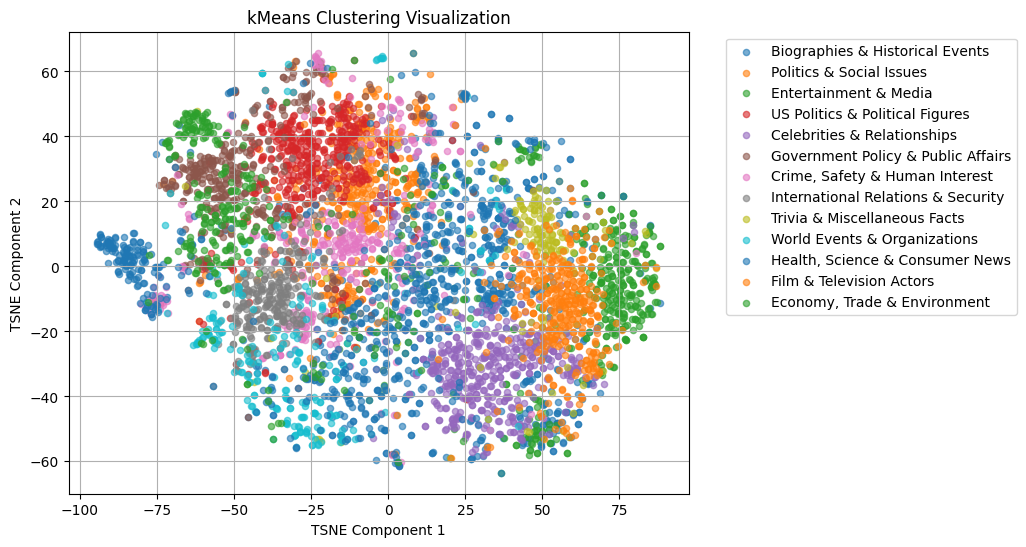



Topic Distribution: domain
Health, Science & Consumer News       41445
Celebrities & Relationships           33052
US Politics & Political Figures       28819
Politics & Social Issues              27474
Biographies & Historical Events       27135
Entertainment & Media                 24960
Government Policy & Public Affairs    24946
Film & Television Actors              22815
Crime, Safety & Human Interest        21505
Economy, Trade & Environment          21495
International Relations & Security    18431
World Events & Organizations          16872
Trivia & Miscellaneous Facts          10273
Name: count, dtype: int64


In [10]:
data = add_domain(data, 
                  k=config["domain_tagging"]["n_domains"],
                  tokenizer_model = config["tokenization"]["tokenizer_model"],
                  save_embeddings=config["domain_tagging"]["save_embeddings"], 
                  use_saved_embeddings=config["domain_tagging"]["use_saved_embeddings"],
                  plot_kmeans=config["domain_tagging"]["plot"])

## Data Augmentation

### Paraphrasing

In [11]:
if config["augmentation"]["paraphrasing"]["enabled"]:
    if config["augmentation"]["methods"]["equalized"]:
        print(f"Using Data Augmentation method 'equalized' \n")
        samples_per_domain = config["augmentation"]["augmentation_budget"] // config["domain_tagging"]["n_domains"]
        samples_to_augment = {domain: samples_per_domain for domain in data["domain"].unique()}

    elif config["augmentation"]["methods"]["demand_based"]:
        print(f"Using Data Augmentation method 'demand_based' \n")
        samples_to_augment = augmentation_threshold(data, config["augmentation"]["augmentation_budget"])

    for domain, n_samples in samples_to_augment.items():
        if n_samples == 0:
            continue

        df_domain = data[data["domain"] == domain]
        n = min(n_samples, len(df_domain))
        df_domain = df_domain.sample(n=n).copy()

        print(f"Paraphrasing {n} datapoints from domain '{domain}'...")
        df_domain["text"] = [paraphrase(text) for text in tqdm(df_domain["text"], desc=f"Paraphrasing '{domain}'", leave=False)]

        data = pd.concat([data, df_domain], ignore_index=True)

### Style Transfer

In [12]:
if config["augmentation"]["style_transfer"]["enabled"]:
    if config["augmentation"]["methods"]["equalized"]:
        print(f"Using Data Augmentation method 'equalized' \n")
        samples_per_domain = config["augmentation"]["augmentation_budget"] // config["domain_tagging"]["n_domains"]
        samples_to_augment = {domain: samples_per_domain for domain in data["domain"].unique()}

    elif config["augmentation"]["methods"]["demand_based"]:
        print(f"Using Data Augmentation method 'demand_based' \n")
        samples_to_augment = augmentation_threshold(data, config["augmentation"]["augmentation_budget"])

    target_styles = [
        "Neutral journalistic",
        "Slightly formal",
        "Slightly informal",
        "Objective report",
        "Simplified for general audience",
        "Summarized headline-style",
        "Explanatory tone",
        "SMS/Chat Message Style",
        "Social Media Post",
        "Podcast Transcript Style"
    ]

    for domain, n_samples in samples_to_augment.items():
        if n_samples == 0:
            continue

        augmented_texts = []
        df_domain = data[data["domain"] == domain]
        n = min(n_samples, len(df_domain))
        df_domain = df_domain.sample(n=n).copy()

        print(f"Transfering style for {n} datapoints from domain '{domain}'...")
        augmented_texts = [transfer_style(text, choice(target_styles)) for text in tqdm(df_domain["text"], desc=f"Style Transfer for '{domain}'", leave=False)]

        df_domain["text"] = augmented_texts

        data = pd.concat([data, df_domain], ignore_index=True)

## Data Preprocessing

### Text Cleaning

In [13]:
def clean_text(text, config):
    if config["strip_html"]:
        text = remove_html(text)
    if config["remove_urls"]:
        text = remove_urls(text)
    if config["remove_digits"]:
        text = remove_digits(text)
    if config["remove_punctuation"]:
        text = remove_punctuation(text)
    if config["remove_special_chars"]:
        text = remove_special_characters(text)
    if config["lowercase"]:
        text = to_lowercase(text)
    if config["normalize_whitespace"]:
        text = normalize_whitespace(text)
    
    return text

In [14]:
data["text"] = data["text"].apply(lambda x: clean_text(x, config["preprocessing"]))

### Balancing domain and label

In [15]:
if config["balance_data"]["balance"]:
    data = balance_data(data, tolerance=config["balance_data"]["balance_tolerance"])

## Save Output

In [16]:
if config["test_set"]["test_cross_domains"]:
    n = config["test_set"]["n_domains"]
    if config["test_set"]["random_domains"]:
        test_domains = pd.Series(data["domain"].unique()).sample(n).tolist()
    else:
        if config["test_set"]["use_manual_domains"]:
            test_domains = config["test_set"]["manual_domains"]
        else:
            test_domains = data["domain"].value_counts().sort_values(ascending=True).head(n).index.tolist()

    test_data = data[data["domain"].isin(test_domains)]
    train_val_data = data[~data["domain"].isin(test_domains)]

    folder_attribute = "cross_domain"

else:
    train_val_data, test_data = train_test_split(data, test_size=config["test_set"]["test_size"])

    folder_attribute = "in_domain"

augmented = any([config["augmentation"]["paraphrasing"]["enabled"],
                config["augmentation"]["style_transfer"]["enabled"]])

balanced = config["balance_data"]["balance"]

folder_name = {
    (False, False): 'raw',
    (True,  False): 'balanced',
    (False, True):  'augmented',
    (True,  True):  'balanced_augmented'
}[(balanced, augmented)]

folder_path = os.path.join(config['output'], folder_attribute, folder_name)

if not os.path.isdir(folder_path):
    os.makedirs(folder_path)

train_val_data.to_parquet(f"{folder_path}/preprocessed_data_train_val.parquet", index=False)
test_data.to_parquet(f"{folder_path}/preprocessed_data_test.parquet", index=False)

print(f"Successfully exported train/val and test data to <{folder_path}>")
    

Successfully exported train/val and test data to <output/cross_domain/raw>
